In [1]:
import numpy as np
import pandas as pd
import os, shutil, json
import matplotlib.pyplot as plt
import keras
from PIL import Image
from pathlib import Path
from statistics import mean 
from keras import backend as K
from keras.models import Sequential, load_model
from keras.optimizers import RMSprop, Adam, SGD
from keras.preprocessing import image
from keras.utils.np_utils import to_categorical
from keras.losses import categorical_crossentropy, binary_crossentropy, mean_squared_error, mean_squared_logarithmic_error
from keras.preprocessing.image import img_to_array, ImageDataGenerator
from keras import layers, models, regularizers, backend, utils
from keras.layers import Activation, BatchNormalization, Conv2D, Conv2DTranspose, Dense, Dropout, Flatten, initializers, InputSpec, Input, LeakyReLU, MaxPooling2D, Reshape

abs_path = r'%s' % os.getcwd().replace('\\','/')

Using TensorFlow backend.
C:\Users\Pichau\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Pichau\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Pichau\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Pichau\Anaconda3\lib\site-packages\tensorflow\python\framework\dtype

In [2]:
Imagens_DataFrame = pd.read_csv("./1_imagens_Mckinsey666.csv") 
Imagens_DataFrame.head()

,path,width,height,size
0,0_2000.jpg,63,63,63 63
1,10000_2004.jpg,62,62,62 62
2,10001_2004.jpg,79,79,79 79
3,10002_2004.jpg,51,51,51 51
4,10003_2004.jpg,77,77,77 77


In [3]:
Imagens_DataFrame.groupby('size').count().sort_values('path').tail()

,path,width,height
size,,,
90 90,1516,1516,1516
95 95,1530,1530,1530
94 94,1534,1534,1534
96 96,1556,1556,1556
92 92,1636,1636,1636


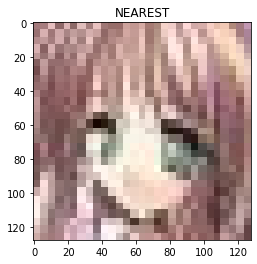

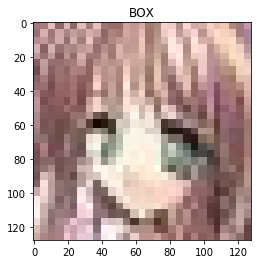

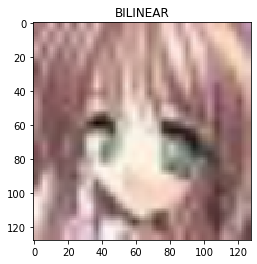

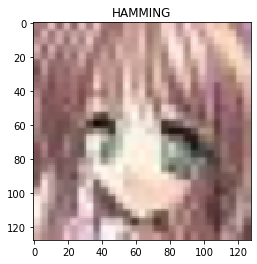

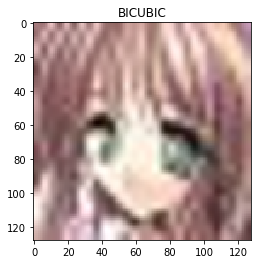

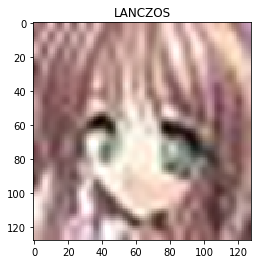

In [4]:
#rede = rede()
#rede.build_network()
im = Image.open("./1_Mckinsey666/7_2000.jpg")
ims = []
size = (128,128)
ims.append(im.resize(size,Image.NEAREST))
ims.append(im.resize(size,Image.BOX))
ims.append(im.resize(size,Image.BILINEAR))
ims.append(im.resize(size,Image.HAMMING))
ims.append(im.resize(size,Image.BICUBIC))
ims.append(im.resize(size,Image.LANCZOS))

plt.subplot(111)
plt.title("NEAREST")
plt.imshow(ims[0])
plt.show()
plt.subplot(111)
plt.title("BOX")
plt.imshow(ims[1])
plt.show()
plt.subplot(111)
plt.title("BILINEAR")
plt.imshow(ims[2])
plt.show()
plt.subplot(111)
plt.title("HAMMING")
plt.imshow(ims[3])
plt.show()
plt.subplot(111)
plt.title("BICUBIC")
plt.imshow(ims[4])
plt.show()
plt.subplot(111)
plt.title("LANCZOS")
plt.imshow(ims[5])
plt.show()

# Modelo Genérico

In [5]:
class rede:
    def __init__(self, batch_size = 20, images_size = 64):
        self.generator_input = 100
        self.latent_dim = 32
        self.height = images_size
        self.width = images_size
        self.channels = 3
        self.iterations = 20000
        self.batch_size = batch_size
        self.NPZ_file_path = os.path.join(abs_path, "2_imagens_Mckinsey666_"+str(self.height)+"_"+str(self.height)+".npz").replace('\\','/')
        self.create_numpy_file()
        self.my_ReduceLROnPlateau_losses = []
        self.my_ReduceLROnPlateau_sentinela = 0
        self.generator = []
        self.discriminator = []
        self.gan = []
        
        images_path = os.path.join(abs_path,'2_Generated_Images_' + str(self.height) + '_' + str(self.height)).replace('\\','/')
        if not os.path.exists(images_path):
            os.mkdir(images_path)
        self.save_dir = images_path
        
    def create_numpy_file(self):
        imagens_x = []
        if not os.path.exists(self.NPZ_file_path):
            Imagens_DataFrame = pd.read_csv("./1_imagens_Mckinsey666.csv")
            for index, row in Imagens_DataFrame.iterrows():
                    image_path = os.path.join(abs_path, '1_Mckinsey666', row['path']).replace('\\','/')
                    image = Image.open(image_path)
                    newsize = (self.height, self.width)
                    image = image.resize(newsize, Image.LANCZOS) 
                    image_numpy = np.asarray(image)
                    imagens_x.append(image_numpy)
                    #imagens_x.append(np.rot90(image_numpy))
                    #imagens_x.append(np.rot90(image_numpy, 3))

            imagens_x = np.asarray(imagens_x, dtype=np.float32)
            np.savez(self.NPZ_file_path, x=imagens_x)
    
    def get_images_as_nparray(self):
        with np.load(self.NPZ_file_path) as data:
            imagens_x = data['x']
        #x_train = imagens_x.reshape((imagens_x.shape[0],) + (self.height, self.width, self.channels)).astype('float32') / 255.
        x_train = (imagens_x.reshape((imagens_x.shape[0],) + (self.height, self.width, self.channels)).astype('float32') - 127.5 ) / 127.5
        #x_train = (imagens_x.reshape((imagens_x.shape[0],) + (self.height, self.width, self.channels)).astype('float32') / 127.5 ) - 0.5
        return x_train
        
    def create_generator(self):
        generator_input = keras.Input(shape=(self.generator_input,))
        
        x = Dense(128 * int(self.height/2) * int(self.width/2))(generator_input)
        x = LeakyReLU()(x)
        x = Reshape((int(self.height/2), int(self.width/2), 128))(x)

        x = Conv2D(256, 5, padding='same')(x)
        x = LeakyReLU()(x)

        x = Conv2DTranspose(256, 4, strides=2, padding='same')(x)
        x = LeakyReLU()(x)
        x = Conv2D(256, 5, padding='same')(x)
        x = LeakyReLU()(x)
        x = Conv2D(256, 5, padding='same')(x)
        x = LeakyReLU()(x)

        #Produces a 32 × 32 1-channel feature map (shape of a CIFAR10 image)
        x = Conv2D(self.channels, 7, activation='tanh', padding='same')(x)
        #Instantiates the generator model, which maps the input of shape (latent_dim,) into an image of shape (32, 32, 3)
        model = keras.models.Model(generator_input, x)
        
        return model
        
    
    def create_discriminator(self):
        discriminator_input = Input(shape=(self.height, self.width, self.channels))
        x = Conv2D(128, 3)(discriminator_input)
        x = LeakyReLU()(x)

        x = Conv2D(128, 4, strides=2)(x)
        x = LeakyReLU()(x)

        x = Conv2D(128, 4, strides=2)(x)
        x = LeakyReLU()(x)

        x = Conv2D(128, 4, strides=2)(x)
        x = LeakyReLU()(x)

        x = Flatten()(x)
        x = Dropout(0.4)(x)
        x = Dense(1, activation='sigmoid')(x)
        model = keras.models.Model(discriminator_input, x)

        discriminator_optimizer = keras.optimizers.RMSprop(
                lr=0.0008,
                clipvalue=1.0, #Uses gradient clipping (by value) in the optimizer
                decay=1e-8) #To stabilize training, uses learning-rate decay
        model.compile(optimizer=Adam(0.0001, beta_1=0.5, beta_2=0.9), loss='binary_crossentropy')
        #model.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')
        return model
    
    def create_adversarial_net(self):
        #Sets discriminator weights to non-trainable (this will only apply to the gan model) 
        self.discriminator = self.create_discriminator()
        self.generator = self.create_generator()
        
        self.discriminator.trainable = False
        gan_input = keras.Input(shape=(self.generator_input,))
        gan_output = self.discriminator(self.generator(gan_input))
        self.gan = keras.models.Model(gan_input, gan_output)
        gan_optimizer = RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
        #self.gan.compile(optimizer=gan_optimizer, loss="binary_crossentropy")
        self.gan.compile(optimizer=Adam(0.0001, beta_1=0.5, beta_2=0.9), loss='binary_crossentropy')

    def my_ReduceLROnPlateau_loss(self, new_loss, step_of_iterations, factor = 0.5, patience = 10, epsilon = 1e-04, cooldown = 0, min_lr=0):
        #Se a lista estiver cheia, remove o primeiro elemento
        if len(self.my_ReduceLROnPlateau_losses) == patience:
            self.my_ReduceLROnPlateau_losses.pop(0)
            
        #Se for lista, existirá dois valores dentro, então  obtém só o primeiro
        if type(new_loss) is list:
            new_loss = new_loss[0]
        self.my_ReduceLROnPlateau_losses.append(new_loss)
        
        valor_antigo = float(K.get_value(self.discriminator.optimizer.lr))
        #Checa se a lista de pesos está cheia, a quantas iterações foi a última alteração
        if len(self.my_ReduceLROnPlateau_losses) == 10 and (step_of_iterations - self.my_ReduceLROnPlateau_sentinela) > cooldown and valor_antigo > min_lr:
            valor_min = mean(self.my_ReduceLROnPlateau_losses) - epsilon
            valor_max = mean(self.my_ReduceLROnPlateau_losses) + epsilon
            #verifica se houve alterações nos "Losses" nas últimas "patience" épocas
            validacao = [ (loss < valor_min or loss > valor_max) for loss in self.my_ReduceLROnPlateau_losses]
            if False in validacao: 
                valor_novo = valor_antigo * factor
                K.set_value(self.discriminator.optimizer.lr, valor_novo)
                print("[CALLBACK] Learning Rate atualizado na época {} de {} para {}".format(step_of_iterations, valor_antigo, valor_novo))
                #Se houver uma alteração, esprar "cooldown" rodadas para fazer uma nova alteração
                self.my_ReduceLROnPlateau_sentinela = step_of_iterations
                
    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)
    
    def get_randomly_batch_images(self, x_train):
        pacotes = x_train.shape[0] // self.batch_size
        inicio_batch = int(pacotes * np.random.randint(self.batch_size + 1, size=1))
        final_batch = int(inicio_batch + self.batch_size)
        if final_batch > x_train.shape[0]:
            diferenca = final_batch - x_train.shape[0]
            real_images = np.concatenate((x_train[inicio_batch:], x_train[:diferenca]), axis=0)
            #print("{} {} {} {} {} {} {}".format(inicio_batch, final_batch, x_train.shape[0], x_train[inicio_batch:].shape, x_train[:diferenca].shape, diferenca, real_images.shape))
        else:
            real_images = x_train[inicio_batch:final_batch]
        assert real_images.shape == (self.batch_size, self.height, self.height, self.channels)
        return real_images
    
    def build_network(self):
        start = 0
        self.create_adversarial_net()
        x_train = self.get_images_as_nparray()
        
        for step in range(self.iterations):            
            #TREINAR O DISCRIMINATOR
            random_latent_vectors = np.random.normal(size=(self.batch_size, self.generator_input))
            generated_images = self.generator.predict(random_latent_vectors)

            stop = start + self.batch_size
            real_images = x_train[start: stop]

            #real_images = self.get_randomly_batch_images(x_train)
            combined_images = np.concatenate([generated_images, real_images])
            labels = np.concatenate([np.zeros((self.batch_size, 1), dtype=np.float32), np.ones((self.batch_size, 1), dtype=np.float32)])
            #labels = np.concatenate([-np.ones((self.batch_size, 1)), np.ones((self.batch_size, 1))])
            #Adds random noise to the labels—an important trick!
            labels += 0.05 * np.random.random(labels.shape)
            d_loss = self.discriminator.train_on_batch(combined_images, labels)
            
            #TREINAR O GENERATOR
            random_latent_vectors = np.random.normal(size=(self.batch_size, self.generator_input))
            misleading_targets = np.ones((self.batch_size, 1), dtype=np.float32)
            a_loss = self.gan.train_on_batch(random_latent_vectors, misleading_targets)
            
            #CALLBACKS
            self.my_ReduceLROnPlateau_loss(d_loss, step, patience=15, cooldown = 15)

            start += self.batch_size
            if start > len(x_train) - self.batch_size:
                start = 0

            if step % 100 == 0 or step == self.iterations-1:
                #Saves model weights
                self.gan.save("2_GAN_model_gan_"+str(self.height)+"_"+str(self.height)+".h5")
                self.generator.save("2_Generator_model_gan_"+str(self.height)+"_"+str(self.height)+".h5")
                #Prints metrics
                print('{} - discriminator loss: {} - adversarial loss: {}'.format(step, d_loss, a_loss))
                #Saves one generated image
                #img = image.array_to_img(generated_images[0] * 255., scale=False)
                img = image.array_to_img(np.squeeze(np.round((generated_images[0] * 127.5) + 127.5).astype(np.uint8)), scale=False)
                #img = image.array_to_img((generated_images[0] * 127.5) + 127.5, scale=False)
                img.save(os.path.join(self.save_dir,'2_GAN_' + str(step) + '_generated_anime.png'))
                #Saves one real image for comparison
                #img = image.array_to_img(real_images[0] * 255., scale=False)
                img = image.array_to_img(np.squeeze(np.round((real_images[0] * 127.5) + 127.5).astype(np.uint8)), scale=False)
                #img = image.array_to_img((real_images[0] * 127.5) + 127.5, scale=False)
                img.save(os.path.join(self.save_dir,'2_GAN_' + str(step) + '_real_anime.png'))

In [6]:
#rede = rede(32, 64)
#rede.build_network()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


C:\Users\Pichau\Anaconda3\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 - discriminator loss: 0.6827364563941956 - adversarial loss: 0.6926941275596619
1 - discriminator loss: 0.6458845734596252 - adversarial loss: 0.6862236261367798
2 - discriminator loss: 0.6165152788162231 - adversarial loss: 0.6671100854873657
3 - discriminator loss: 0.5985109806060791 - adversarial loss: 0.6137774586677551
4 - discriminator loss: 0.6252298951148987 - adversarial loss: 0.5304689407348633
5 - discriminator loss: 0.714085042476654 - adversarial loss: 0.5179753303527832
6 - discriminator loss: 0.6851739287376404 - adversarial loss: 0.591289758682251
7 - discriminator loss: 0.6085881590843201 - adversarial loss: 0.7374847531318665
8 - discriminator loss: 0.5267807245254517 - adversarial loss: 0.8864290118217468
9 - discriminator loss: 0.479580283164978 - adversarial loss: 1.1079494953155518
10 - discriminator loss: 0.3703472316265106 - adversarial loss: 1.3520913124084473
11 - discriminator loss: 0.33303597569465637 - adversarial loss: 1.5859166383743286
12 - discriminat

99 - discriminator loss: 0.6513305306434631 - adversarial loss: 0.6805225610733032
100 - discriminator loss: 0.6429417729377747 - adversarial loss: 0.9753234386444092
101 - discriminator loss: 0.5794950723648071 - adversarial loss: 0.9118501543998718
102 - discriminator loss: 0.6301144361495972 - adversarial loss: 0.8709381222724915
103 - discriminator loss: 0.6303552389144897 - adversarial loss: 0.684907078742981
104 - discriminator loss: 0.7233012914657593 - adversarial loss: 0.6764391660690308
105 - discriminator loss: 0.7240907549858093 - adversarial loss: 0.6137877702713013
106 - discriminator loss: 0.7329254150390625 - adversarial loss: 0.6560803055763245
107 - discriminator loss: 0.7860876321792603 - adversarial loss: 0.6012512445449829
108 - discriminator loss: 0.7475384473800659 - adversarial loss: 0.7103939056396484
109 - discriminator loss: 0.826340913772583 - adversarial loss: 0.7468686699867249
110 - discriminator loss: 0.8628127574920654 - adversarial loss: 0.762443304061

197 - discriminator loss: 0.7296055555343628 - adversarial loss: 0.7507644891738892
198 - discriminator loss: 0.65503990650177 - adversarial loss: 0.7900758385658264
199 - discriminator loss: 0.63184654712677 - adversarial loss: 0.7687204480171204
200 - discriminator loss: 0.6399789452552795 - adversarial loss: 0.8492908477783203
201 - discriminator loss: 0.6737817525863647 - adversarial loss: 0.9148682355880737
202 - discriminator loss: 0.6233139038085938 - adversarial loss: 0.9953110218048096
203 - discriminator loss: 0.6148945093154907 - adversarial loss: 0.8420878648757935
204 - discriminator loss: 0.5922063589096069 - adversarial loss: 0.8681896924972534
205 - discriminator loss: 0.5647289752960205 - adversarial loss: 0.8326159715652466
206 - discriminator loss: 0.5857062339782715 - adversarial loss: 0.9716176986694336
207 - discriminator loss: 0.6149358749389648 - adversarial loss: 1.078789472579956
208 - discriminator loss: 0.6279624104499817 - adversarial loss: 1.20816564559936

295 - discriminator loss: 0.5798991918563843 - adversarial loss: 0.7688930034637451
296 - discriminator loss: 0.6130715608596802 - adversarial loss: 0.7830855846405029
297 - discriminator loss: 0.7057338356971741 - adversarial loss: 0.6177598834037781
298 - discriminator loss: 0.7223409414291382 - adversarial loss: 0.5727142095565796
299 - discriminator loss: 0.6495789289474487 - adversarial loss: 0.6742573976516724
300 - discriminator loss: 0.6166523694992065 - adversarial loss: 0.7671235799789429
301 - discriminator loss: 0.5520997047424316 - adversarial loss: 0.8742586374282837
302 - discriminator loss: 0.5085208415985107 - adversarial loss: 0.8664913177490234
303 - discriminator loss: 0.591590166091919 - adversarial loss: 1.026736855506897
304 - discriminator loss: 0.6384056806564331 - adversarial loss: 0.7043037414550781
305 - discriminator loss: 0.6154029965400696 - adversarial loss: 0.9809255599975586
306 - discriminator loss: 0.608842134475708 - adversarial loss: 1.015442371368

393 - discriminator loss: 0.6293805837631226 - adversarial loss: 1.129389762878418
394 - discriminator loss: 0.576842188835144 - adversarial loss: 0.975475013256073
395 - discriminator loss: 0.6303807497024536 - adversarial loss: 0.8517796397209167
396 - discriminator loss: 0.6667357683181763 - adversarial loss: 0.9248125553131104
397 - discriminator loss: 0.6138566732406616 - adversarial loss: 1.0184333324432373
398 - discriminator loss: 0.6421561241149902 - adversarial loss: 0.9271031618118286
399 - discriminator loss: 0.644484281539917 - adversarial loss: 0.5988681316375732
400 - discriminator loss: 0.6433661580085754 - adversarial loss: 0.702736496925354
401 - discriminator loss: 0.6504491567611694 - adversarial loss: 0.7295582294464111
402 - discriminator loss: 0.7295281887054443 - adversarial loss: 0.7225430011749268
403 - discriminator loss: 0.7744957208633423 - adversarial loss: 0.8224460482597351
404 - discriminator loss: 0.871468186378479 - adversarial loss: 0.759168148040771

491 - discriminator loss: 0.7393655776977539 - adversarial loss: 0.7456141114234924
492 - discriminator loss: 0.737508237361908 - adversarial loss: 0.7888504266738892
493 - discriminator loss: 0.6642019748687744 - adversarial loss: 0.7983572483062744
494 - discriminator loss: 0.6594427824020386 - adversarial loss: 0.8175865411758423
495 - discriminator loss: 0.6686323285102844 - adversarial loss: 0.9883920550346375
496 - discriminator loss: 0.6189026832580566 - adversarial loss: 1.0442010164260864
497 - discriminator loss: 0.6529608964920044 - adversarial loss: 0.9061414003372192
498 - discriminator loss: 0.5771620273590088 - adversarial loss: 0.8953058123588562
499 - discriminator loss: 0.6132383346557617 - adversarial loss: 0.917479932308197
500 - discriminator loss: 0.5835987329483032 - adversarial loss: 0.8790864944458008
501 - discriminator loss: 0.5931546092033386 - adversarial loss: 0.8791916370391846
502 - discriminator loss: 0.678195595741272 - adversarial loss: 0.792146742343

589 - discriminator loss: 0.6345199346542358 - adversarial loss: 0.8053778409957886
590 - discriminator loss: 0.612480640411377 - adversarial loss: 0.764991819858551
591 - discriminator loss: 0.6094843745231628 - adversarial loss: 0.7480148673057556
592 - discriminator loss: 0.6627085208892822 - adversarial loss: 0.7577849626541138
593 - discriminator loss: 0.6463821530342102 - adversarial loss: 0.7469297051429749
594 - discriminator loss: 0.6699666976928711 - adversarial loss: 0.7746186256408691
595 - discriminator loss: 0.649418830871582 - adversarial loss: 0.7367164492607117
596 - discriminator loss: 0.7007213830947876 - adversarial loss: 0.6309036612510681
597 - discriminator loss: 0.7222165465354919 - adversarial loss: 0.680173933506012
598 - discriminator loss: 0.7005180716514587 - adversarial loss: 0.7319158315658569
599 - discriminator loss: 0.6689269542694092 - adversarial loss: 0.7883572578430176
600 - discriminator loss: 0.6399996280670166 - adversarial loss: 0.7448235750198

687 - discriminator loss: 0.6632950305938721 - adversarial loss: 0.8358559608459473
688 - discriminator loss: 0.7176190614700317 - adversarial loss: 0.8537486791610718
689 - discriminator loss: 0.6628963947296143 - adversarial loss: 1.003736972808838
690 - discriminator loss: 0.5930331945419312 - adversarial loss: 0.9607503414154053
691 - discriminator loss: 0.5920929312705994 - adversarial loss: 0.8788454532623291
692 - discriminator loss: 0.6457333564758301 - adversarial loss: 0.8000125288963318
693 - discriminator loss: 0.6626390218734741 - adversarial loss: 0.8409760594367981
694 - discriminator loss: 0.774983823299408 - adversarial loss: 0.8401830792427063
695 - discriminator loss: 0.7658399939537048 - adversarial loss: 0.8153318166732788
696 - discriminator loss: 0.702440619468689 - adversarial loss: 0.8488144874572754
697 - discriminator loss: 0.6815882325172424 - adversarial loss: 0.761818528175354
698 - discriminator loss: 0.6600099802017212 - adversarial loss: 0.7526319026947

785 - discriminator loss: 0.6336085796356201 - adversarial loss: 0.8084434270858765
786 - discriminator loss: 0.6513944864273071 - adversarial loss: 0.8302159905433655
787 - discriminator loss: 0.6446075439453125 - adversarial loss: 0.8590172529220581
788 - discriminator loss: 0.6528818607330322 - adversarial loss: 0.7793651819229126
789 - discriminator loss: 0.6856762170791626 - adversarial loss: 0.7387108206748962
790 - discriminator loss: 0.7437493801116943 - adversarial loss: 0.6900976896286011
791 - discriminator loss: 0.8060818314552307 - adversarial loss: 0.6515331268310547
792 - discriminator loss: 0.7716763019561768 - adversarial loss: 0.7202715277671814
793 - discriminator loss: 0.7275370359420776 - adversarial loss: 0.7637209296226501
794 - discriminator loss: 0.633432149887085 - adversarial loss: 0.9269046783447266
795 - discriminator loss: 0.6455366611480713 - adversarial loss: 0.9522836208343506
796 - discriminator loss: 0.6940169334411621 - adversarial loss: 0.8112374544

883 - discriminator loss: 0.9964206218719482 - adversarial loss: 0.9699749946594238
884 - discriminator loss: 0.7402904033660889 - adversarial loss: 1.3141862154006958
885 - discriminator loss: 0.6023935675621033 - adversarial loss: 1.3129807710647583
886 - discriminator loss: 0.6004359722137451 - adversarial loss: 1.0122441053390503
887 - discriminator loss: 0.7356103658676147 - adversarial loss: 0.8412604331970215
888 - discriminator loss: 0.7023236155509949 - adversarial loss: 0.9093931913375854
889 - discriminator loss: 0.6793879866600037 - adversarial loss: 1.0615990161895752
890 - discriminator loss: 0.6903992891311646 - adversarial loss: 1.015259027481079
891 - discriminator loss: 0.6556033492088318 - adversarial loss: 0.9082953333854675
892 - discriminator loss: 0.5731397867202759 - adversarial loss: 1.0542070865631104
893 - discriminator loss: 0.4955337643623352 - adversarial loss: 1.0912251472473145
894 - discriminator loss: 0.5898417234420776 - adversarial loss: 0.9436670541

981 - discriminator loss: 0.7134451270103455 - adversarial loss: 0.7758029699325562
982 - discriminator loss: 0.6955140829086304 - adversarial loss: 0.7426604628562927
983 - discriminator loss: 0.6507731676101685 - adversarial loss: 0.7390725016593933
984 - discriminator loss: 0.6209233999252319 - adversarial loss: 0.7616902589797974
985 - discriminator loss: 0.6662449836730957 - adversarial loss: 0.708378791809082
986 - discriminator loss: 0.7039951086044312 - adversarial loss: 0.6671165227890015
987 - discriminator loss: 0.7897042036056519 - adversarial loss: 0.6950603723526001
988 - discriminator loss: 0.8964061141014099 - adversarial loss: 0.6569240093231201
989 - discriminator loss: 0.8270189762115479 - adversarial loss: 0.8328893780708313
990 - discriminator loss: 0.6667664647102356 - adversarial loss: 0.9733062982559204
991 - discriminator loss: 0.5682364702224731 - adversarial loss: 0.9887077212333679
992 - discriminator loss: 0.5963362455368042 - adversarial loss: 0.9992192387

1078 - discriminator loss: 0.7402423024177551 - adversarial loss: 0.7666659355163574
1079 - discriminator loss: 0.6993066072463989 - adversarial loss: 0.7682523727416992
1080 - discriminator loss: 0.7238541841506958 - adversarial loss: 0.7249215841293335
1081 - discriminator loss: 0.7353188395500183 - adversarial loss: 0.6913784146308899
1082 - discriminator loss: 0.7406940460205078 - adversarial loss: 0.7683145999908447
1083 - discriminator loss: 0.7031219601631165 - adversarial loss: 0.8744696378707886
1084 - discriminator loss: 0.652286171913147 - adversarial loss: 0.9641107320785522
1085 - discriminator loss: 0.6178704500198364 - adversarial loss: 0.9770947694778442
1086 - discriminator loss: 0.6500153541564941 - adversarial loss: 0.8339117765426636
1087 - discriminator loss: 0.7542661428451538 - adversarial loss: 0.6996095180511475
1088 - discriminator loss: 0.7684742212295532 - adversarial loss: 0.7475795149803162
1089 - discriminator loss: 0.8033884167671204 - adversarial loss: 

1175 - discriminator loss: 0.7438485622406006 - adversarial loss: 0.695142388343811
1176 - discriminator loss: 0.7522222995758057 - adversarial loss: 0.7020730376243591
1177 - discriminator loss: 0.7370457649230957 - adversarial loss: 0.7094942331314087
1178 - discriminator loss: 0.7473605871200562 - adversarial loss: 0.6373976469039917
1179 - discriminator loss: 0.7091434597969055 - adversarial loss: 0.6882486343383789
1180 - discriminator loss: 0.6703329086303711 - adversarial loss: 0.674728274345398
1181 - discriminator loss: 0.6760903596878052 - adversarial loss: 0.6481558084487915
1182 - discriminator loss: 0.6764487028121948 - adversarial loss: 0.6459250450134277
1183 - discriminator loss: 0.6936637163162231 - adversarial loss: 0.6858140826225281
1184 - discriminator loss: 0.7116940021514893 - adversarial loss: 0.7270046472549438
1185 - discriminator loss: 0.6852349638938904 - adversarial loss: 0.7761189937591553
1186 - discriminator loss: 0.6728810667991638 - adversarial loss: 0

1272 - discriminator loss: 0.6992313861846924 - adversarial loss: 0.7023220658302307
1273 - discriminator loss: 0.7404069304466248 - adversarial loss: 0.6914951801300049
1274 - discriminator loss: 0.7132915258407593 - adversarial loss: 0.7201282978057861
1275 - discriminator loss: 0.7181270122528076 - adversarial loss: 0.6907145977020264
1276 - discriminator loss: 0.6922398805618286 - adversarial loss: 0.7284207940101624
1277 - discriminator loss: 0.6705244779586792 - adversarial loss: 0.8070322275161743
1278 - discriminator loss: 0.6642320156097412 - adversarial loss: 0.8182722330093384
1279 - discriminator loss: 0.6892887353897095 - adversarial loss: 0.6963148713111877
1280 - discriminator loss: 0.720465362071991 - adversarial loss: 0.5920633673667908
1281 - discriminator loss: 0.7378129363059998 - adversarial loss: 0.6090219020843506
1282 - discriminator loss: 0.6875526905059814 - adversarial loss: 0.6014789938926697
1283 - discriminator loss: 0.7492122650146484 - adversarial loss: 

1369 - discriminator loss: 0.7009702324867249 - adversarial loss: 0.6443911790847778
1370 - discriminator loss: 0.734341025352478 - adversarial loss: 0.6242201328277588
1371 - discriminator loss: 0.7401705980300903 - adversarial loss: 0.6584725379943848
1372 - discriminator loss: 0.7407262325286865 - adversarial loss: 0.7666372060775757
1373 - discriminator loss: 0.6950684785842896 - adversarial loss: 0.7758316993713379
1374 - discriminator loss: 0.6789417862892151 - adversarial loss: 0.755752444267273
1375 - discriminator loss: 0.7163703441619873 - adversarial loss: 0.6906826496124268
1376 - discriminator loss: 0.6945797204971313 - adversarial loss: 0.6521618366241455
1377 - discriminator loss: 0.7103128433227539 - adversarial loss: 0.6459274291992188
1378 - discriminator loss: 0.7142958641052246 - adversarial loss: 0.6836243867874146
1379 - discriminator loss: 0.6980694532394409 - adversarial loss: 0.6996147632598877
1380 - discriminator loss: 0.6879073977470398 - adversarial loss: 0

1466 - discriminator loss: 0.7151085138320923 - adversarial loss: 0.6748042702674866
1467 - discriminator loss: 0.7184639573097229 - adversarial loss: 0.6745489835739136
1468 - discriminator loss: 0.6981834173202515 - adversarial loss: 0.6672422885894775
1469 - discriminator loss: 0.6996675729751587 - adversarial loss: 0.6591958999633789
1470 - discriminator loss: 0.7093113660812378 - adversarial loss: 0.6594305038452148
1471 - discriminator loss: 0.6900595426559448 - adversarial loss: 0.6489081382751465
1472 - discriminator loss: 0.6882038116455078 - adversarial loss: 0.6277996301651001
1473 - discriminator loss: 0.6943151950836182 - adversarial loss: 0.6439396739006042
1474 - discriminator loss: 0.6953920125961304 - adversarial loss: 0.6290451884269714
1475 - discriminator loss: 0.6995419263839722 - adversarial loss: 0.6333572864532471
1476 - discriminator loss: 0.7071986794471741 - adversarial loss: 0.6098429560661316
1477 - discriminator loss: 0.6979439854621887 - adversarial loss:

1563 - discriminator loss: 0.7039565443992615 - adversarial loss: 0.6489713191986084
1564 - discriminator loss: 0.7080378532409668 - adversarial loss: 0.6552259922027588
1565 - discriminator loss: 0.6952705979347229 - adversarial loss: 0.6806931495666504
1566 - discriminator loss: 0.7044714689254761 - adversarial loss: 0.6596916913986206
1567 - discriminator loss: 0.710942804813385 - adversarial loss: 0.6666263341903687
1568 - discriminator loss: 0.7099319100379944 - adversarial loss: 0.6997319459915161
1569 - discriminator loss: 0.7123607397079468 - adversarial loss: 0.7177735567092896
1570 - discriminator loss: 0.6988989114761353 - adversarial loss: 0.7186791896820068
1571 - discriminator loss: 0.7062066793441772 - adversarial loss: 0.7165876626968384
1572 - discriminator loss: 0.702653169631958 - adversarial loss: 0.6932828426361084
1573 - discriminator loss: 0.701668381690979 - adversarial loss: 0.6797147989273071
1574 - discriminator loss: 0.7181897163391113 - adversarial loss: 0.

1660 - discriminator loss: 0.6713460683822632 - adversarial loss: 0.6153805255889893
1661 - discriminator loss: 0.7111170887947083 - adversarial loss: 0.6338329315185547
1662 - discriminator loss: 0.7096474766731262 - adversarial loss: 0.632937490940094
1663 - discriminator loss: 0.7216096520423889 - adversarial loss: 0.6323028802871704
1664 - discriminator loss: 0.7966043949127197 - adversarial loss: 0.6266620755195618
1665 - discriminator loss: 0.7581467032432556 - adversarial loss: 0.7217288017272949
1666 - discriminator loss: 0.6936224102973938 - adversarial loss: 0.7858465909957886
1667 - discriminator loss: 0.6724837422370911 - adversarial loss: 0.8053522109985352
1668 - discriminator loss: 0.6730626821517944 - adversarial loss: 0.7875185012817383
1669 - discriminator loss: 0.6862459182739258 - adversarial loss: 0.7683309316635132
1670 - discriminator loss: 0.6876299381256104 - adversarial loss: 0.7348034381866455
1671 - discriminator loss: 0.6822408437728882 - adversarial loss: 

1757 - discriminator loss: 0.6758993268013 - adversarial loss: 0.7063583731651306
1758 - discriminator loss: 0.6671518087387085 - adversarial loss: 0.6872519254684448
1759 - discriminator loss: 0.677995502948761 - adversarial loss: 0.6247416734695435
1760 - discriminator loss: 0.698359489440918 - adversarial loss: 0.6072832345962524
1761 - discriminator loss: 0.6991926431655884 - adversarial loss: 0.6517559885978699
1762 - discriminator loss: 0.7017467021942139 - adversarial loss: 0.6816445589065552
1763 - discriminator loss: 0.6987200975418091 - adversarial loss: 0.7047462463378906
1764 - discriminator loss: 0.7110922932624817 - adversarial loss: 0.7004374861717224
1765 - discriminator loss: 0.7343701720237732 - adversarial loss: 0.6883770227432251
1766 - discriminator loss: 0.7225714921951294 - adversarial loss: 0.7276288866996765
1767 - discriminator loss: 0.7213054299354553 - adversarial loss: 0.7648059129714966
1768 - discriminator loss: 0.690707266330719 - adversarial loss: 0.766

1854 - discriminator loss: 0.6938144564628601 - adversarial loss: 0.6913349628448486
1855 - discriminator loss: 0.6787657141685486 - adversarial loss: 0.6792157888412476
1856 - discriminator loss: 0.6723468899726868 - adversarial loss: 0.6647008657455444
1857 - discriminator loss: 0.6905212998390198 - adversarial loss: 0.662269115447998
1858 - discriminator loss: 0.6868469715118408 - adversarial loss: 0.6565248370170593
1859 - discriminator loss: 0.6991240978240967 - adversarial loss: 0.6911455988883972
1860 - discriminator loss: 0.6989650726318359 - adversarial loss: 0.6860008239746094
1861 - discriminator loss: 0.7137820720672607 - adversarial loss: 0.6819143295288086
1862 - discriminator loss: 0.7246725559234619 - adversarial loss: 0.6653505563735962
1863 - discriminator loss: 0.7387975454330444 - adversarial loss: 0.6462628245353699
1864 - discriminator loss: 0.7295697927474976 - adversarial loss: 0.6614867448806763
1865 - discriminator loss: 0.7219198942184448 - adversarial loss: 

1951 - discriminator loss: 0.7029715776443481 - adversarial loss: 0.7525285482406616
1952 - discriminator loss: 0.7003780007362366 - adversarial loss: 0.7600939273834229
1953 - discriminator loss: 0.6923772096633911 - adversarial loss: 0.7270687222480774
1954 - discriminator loss: 0.686233401298523 - adversarial loss: 0.7002956867218018
1955 - discriminator loss: 0.6875474452972412 - adversarial loss: 0.6815559267997742
1956 - discriminator loss: 0.7109106183052063 - adversarial loss: 0.6530935168266296
1957 - discriminator loss: 0.7318686842918396 - adversarial loss: 0.6359497308731079
1958 - discriminator loss: 0.7386797070503235 - adversarial loss: 0.6158413290977478
1959 - discriminator loss: 0.7210642695426941 - adversarial loss: 0.6235260963439941
1960 - discriminator loss: 0.7191314697265625 - adversarial loss: 0.6492652893066406
1961 - discriminator loss: 0.7023665904998779 - adversarial loss: 0.643839418888092
1962 - discriminator loss: 0.7022756338119507 - adversarial loss: 0

2048 - discriminator loss: 0.6998169422149658 - adversarial loss: 0.7251758575439453
2049 - discriminator loss: 0.6753287315368652 - adversarial loss: 0.7341038584709167
2050 - discriminator loss: 0.6644144058227539 - adversarial loss: 0.7313842177391052
2051 - discriminator loss: 0.683560311794281 - adversarial loss: 0.7285552620887756
2052 - discriminator loss: 0.705629825592041 - adversarial loss: 0.704275369644165
2053 - discriminator loss: 0.7043588161468506 - adversarial loss: 0.6836313009262085
2054 - discriminator loss: 0.7128951549530029 - adversarial loss: 0.637829065322876
2055 - discriminator loss: 0.7502058744430542 - adversarial loss: 0.6903592944145203
2056 - discriminator loss: 0.7041649222373962 - adversarial loss: 0.7087355852127075
2057 - discriminator loss: 0.6983290314674377 - adversarial loss: 0.6163768768310547
2058 - discriminator loss: 0.7145095467567444 - adversarial loss: 0.622988224029541
2059 - discriminator loss: 0.7232609987258911 - adversarial loss: 0.69

2145 - discriminator loss: 0.6818010807037354 - adversarial loss: 0.7206841111183167
2146 - discriminator loss: 0.6857966780662537 - adversarial loss: 0.7037227153778076
2147 - discriminator loss: 0.696978747844696 - adversarial loss: 0.6743009090423584
2148 - discriminator loss: 0.6943812370300293 - adversarial loss: 0.6722697615623474
2149 - discriminator loss: 0.6904453039169312 - adversarial loss: 0.6463268399238586
2150 - discriminator loss: 0.7072068452835083 - adversarial loss: 0.6227471828460693
2151 - discriminator loss: 0.709871768951416 - adversarial loss: 0.5944435000419617
2152 - discriminator loss: 0.7010901570320129 - adversarial loss: 0.59105384349823
2153 - discriminator loss: 0.6908759474754333 - adversarial loss: 0.589689314365387
2154 - discriminator loss: 0.7039735317230225 - adversarial loss: 0.6494510173797607
2155 - discriminator loss: 0.7098891735076904 - adversarial loss: 0.6575238704681396
2156 - discriminator loss: 0.7000294923782349 - adversarial loss: 0.67

2242 - discriminator loss: 0.6835415363311768 - adversarial loss: 0.6688889265060425
2243 - discriminator loss: 0.6998635530471802 - adversarial loss: 0.6624590754508972
2244 - discriminator loss: 0.7095015048980713 - adversarial loss: 0.6488387584686279
2245 - discriminator loss: 0.6977658867835999 - adversarial loss: 0.6528736352920532
2246 - discriminator loss: 0.6961050033569336 - adversarial loss: 0.6359437704086304
2247 - discriminator loss: 0.7052145600318909 - adversarial loss: 0.6312447190284729
2248 - discriminator loss: 0.7152523994445801 - adversarial loss: 0.6463077068328857
2249 - discriminator loss: 0.6837100386619568 - adversarial loss: 0.6580542325973511
2250 - discriminator loss: 0.683020830154419 - adversarial loss: 0.6465109586715698
2251 - discriminator loss: 0.6939570307731628 - adversarial loss: 0.6428424119949341
2252 - discriminator loss: 0.6935746669769287 - adversarial loss: 0.6492093801498413
2253 - discriminator loss: 0.6871122121810913 - adversarial loss: 

KeyboardInterrupt: 

In [ ]:
def test():
    model = load_model('2_Generator_model_gan_64_64.h5')
    batch_size = 128
    random_latent_vectors = np.random.normal(size=(batch_size, 100))
    generated_images = model.predict(random_latent_vectors)
    images_path = os.path.join(abs_path,'2_Generated_Images_Test_64_64').replace('\\','/')
    if not os.path.exists(images_path):
        os.mkdir(images_path)
    for index in range(batch_size):
        img = image.array_to_img(np.squeeze(np.round((generated_images[index] * 127.5) + 127.5).astype(np.uint8)), scale=False)
        img.save(os.path.join(images_path,'2_GAN_' + str(index+1) + '_generated_anime.png'))
    print("OI")
#test()

In [ ]:
print("Oi")